In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from scipy import sparse
from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

In [3]:
import pandas as pd
import geopandas as gpd
import folium

from fiona.crs import from_epsg

import psycopg2
from netrc import netrc
user, acct, passwd = netrc().authenticators("harris")

In [4]:
# This is because global variables only get fixed at evaluation.... gross.

styles = {}
styles[2]  = lambda feature: {'fillColor': feature['properties']["ncl02_col"], 'fillOpacity' : 0.2, 'weight' : 2, 'color' : 'black'}
styles[3]  = lambda feature: {'fillColor': feature['properties']["ncl03_col"], 'fillOpacity' : 0.2, 'weight' : 2, 'color' : 'black'}
styles[4]  = lambda feature: {'fillColor': feature['properties']["ncl04_col"], 'fillOpacity' : 0.2, 'weight' : 2, 'color' : 'black'}
styles[5]  = lambda feature: {'fillColor': feature['properties']["ncl05_col"], 'fillOpacity' : 0.2, 'weight' : 2, 'color' : 'black'}
styles[10] = lambda feature: {'fillColor': feature['properties']["ncl10_col"], 'fillOpacity' : 0.2, 'weight' : 2, 'color' : 'black'}
styles[15] = lambda feature: {'fillColor': feature['properties']["ncl15_col"], 'fillOpacity' : 0.2, 'weight' : 2, 'color' : 'black'}
styles[20] = lambda feature: {'fillColor': feature['properties']["ncl20_col"], 'fillOpacity' : 0.2, 'weight' : 2, 'color' : 'black'}

### Load maps of Pittsburgh's and Toronto's neighborhods.

In [5]:
to_ne = gpd.read_file("/home/jsaxon/proj/bc/toronto_neighborhoods/NEIGHBORHOODS_WGS84.shp")
to_ne.to_crs(epsg = 4269, inplace = True)
to_ne.AREA_S_CD = to_ne.AREA_S_CD.astype(int) - 1
to_ne.AREA_NAME = to_ne.AREA_NAME.str.replace(r" \([0-9]*\)$", "")
to_ne.rename(columns = {"AREA_S_CD" : "nid", "AREA_NAME" : "name"}, inplace = True)

pi_ne = gpd.read_file("/home/jsaxon/proj/bc/pittsburgh_neighborhoods/Pittsburgh_Neighborhoods.shp")
pi_ne.to_crs(epsg = 4269, inplace = True)
pi_ne.hood_no = pi_ne.hood_no.astype(int)
pi_ne.rename(columns = {"hood_no" : "nid", "hood" : "name"}, inplace = True)

### Merge neighborhoods with businesses, based on a lat/lon location.

In [6]:
def get_businesses_neighborhoods(ne, lon, lat):

    ne.sort_values(by = "nid", inplace = True)
    ne.reset_index(inplace = True, drop = True)

    bz = gpd.GeoDataFrame.from_postgis("""SELECT id bid, geom geometry FROM business 
                                          WHERE ST_Distance(geom, ST_SetSRID(ST_MakePoint({:.2f}, {:.2f}), 4269)) < 0.55;
                                       """.format(lon, lat),
                                       geom_col='geometry', crs = from_epsg(4269), # index_col = "bid", 
                                       con = psycopg2.connect(database = "yelp", user = user, password = passwd,
                                                              host = "saxon.harris.uchicago.edu", port = 5432))

    bz_ne = gpd.tools.sjoin(bz, ne, how = "inner", op = "within").set_index("bid")
    bz_ne.to_crs(epsg = 3162).plot(column = "nid", cmap = "nipy_spectral", markeredgewidth=0.0).set_axis_off()
    return bz_ne[["nid"]]

### Now retrieve all of the reviews, and map businesses to neighborhoods.  Drop businesses outside the city.

In [7]:
def get_reviews(bz_ne):

    ye_re = pd.read_sql("SELECT uid, business bid FROM review;",
                        con = psycopg2.connect(database = "yelp", user = user, password = passwd,
                                               host = "saxon.harris.uchicago.edu", port = 5432))

    ye_re["nid"] = ye_re.bid.map(bz_ne.nid).fillna(-1).astype(int)
    return ye_re[ye_re.nid >= 0][["uid", "nid"]]

### Identify users that have reviewed businesses in at least two neighborhoods.
Reindex from uid to a counter that satisfies the condition -- for building sparse matrix.

In [8]:
def get_reviewers(ye_re):

    user_rev = ye_re.drop_duplicates(["uid", "nid"]).groupby("uid").count()
    user_rev = user_rev[user_rev.nid > 1]
    user_rev.insert(0, "uuid", range(len(user_rev)))
    return user_rev.uuid

### Evaluate the fraction of each "cosmpolitan" user's reviews in each neighborhood. 
This is the list for building our sparse matrix.  We have 36k users left.

In [9]:
def get_neighborhood_weights(ye_re):

    reviewers = get_reviewers(ye_re)
    
    ye_re["uuid"] = ye_re.uid.map(reviewers)
    ye_re = ye_re.loc[~ye_re.uuid.isnull(), ["uid", "uuid", "nid"]]
    ye_re.uuid = ye_re.uuid.astype(int)
    ye_re = ye_re.sort_values(by = ["uid", "nid"])[["uuid", "nid"]]

    ye_re["neighbohood_reviews"] = 1
    ye_re = ye_re.groupby(["uuid", "nid"]).count().reset_index().set_index("uuid", drop = True)
    ye_re["total_reviews"] = ye_re.groupby(ye_re.index).sum().neighbohood_reviews
    ye_re["weight"] = ye_re["neighbohood_reviews"] / ye_re["total_reviews"]
    ye_re.reset_index(inplace = True)
    return ye_re[["uuid", "nid", "weight"]]


In [10]:
def print_matrix(ye_re):

    A = sparse.csr_matrix((ye_re.weight,(ye_re.uuid, ye_re.nid)))
    plt.matshow(A.todense(), cmap=plt.cm.Blues, extent=[0,140,0,36725], aspect=0.002)
    print(A.shape)

### Let's try some biclustering!!

http://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-biclustering-py

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.bicluster.SpectralBiclustering.html#sklearn.cluster.bicluster.SpectralBiclustering

In [11]:
def cmap(cluster_val):
    color = [int(v*255) for v in plt.get_cmap("nipy_spectral")(cluster_val)][:3]
    color_hex = "#{0:02X}{1:02X}{2:02X}".format(*color)
    return color_hex

def make_maps(name, ye_re, ne, lon, lat):
    
    A = sparse.csr_matrix((ye_re.weight,(ye_re.uuid, ye_re.nid)))

    m = folium.Map([lat, lon], tiles='cartodbpositron', zoom_start=10)

    layers = {}
    for ncl in [2, 3, 4, 5, 10, 15, 20]:

        model = SpectralBiclustering(n_clusters = (144, ncl), random_state=0)
        model.fit(A)

        ne["ncl{:02d}".format(ncl)] = model.column_labels_
        ne["ncl{:02d}_val".format(ncl)] = ne["ncl{:02d}".format(ncl)] / (ncl-1)
        ne["ncl{:02d}_col".format(ncl)] = ne["ncl{:02d}_val".format(ncl)].apply(cmap)

        layers[ncl] = folium.GeoJson(ne, name = "{} Levels".format(ncl), 
                                     style_function = styles[ncl])

        layers[ncl].layer_name = "{} Levels".format(ncl)
        layers[ncl].add_to(m)
        
        print(ncl, end = " ")

    print()

    # folium.TileLayer('openstreetmap').add_to(m)
    # folium.TileLayer('Mapbox Control Room').add_to(m)

    folium.LayerControl().add_to(m)
    
    m.save(name + ".html")
    # return m

(36726, 140)
2 3 4 5 10 15 20 


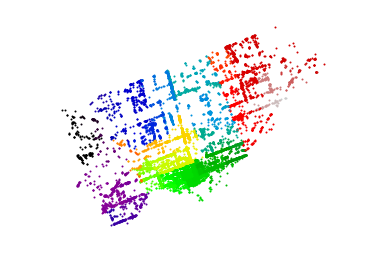

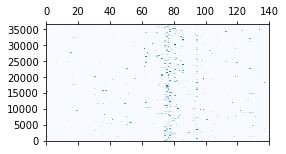

In [12]:
bz_ne = get_businesses_neighborhoods(to_ne, -79.51, 43.73)

ye_re = get_reviews(bz_ne)
ye_re = get_neighborhood_weights(ye_re)

print_matrix(ye_re)

make_maps("toronto", ye_re, to_ne, -79.51, 43.73)

(12643, 91)


/home/jsaxon/anaconda3/lib/python3.5/site-packages/sklearn/cluster/bicluster.py:39: RuntimeWarning: divide by zero encountered in true_divide
  col_diag = np.asarray(1.0 / np.sqrt(X.sum(axis=0))).squeeze()


2 3 4 5 10 15 20 


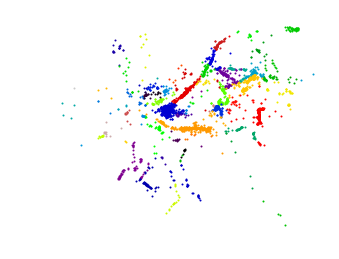

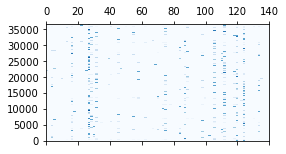

In [13]:
bz_ne = get_businesses_neighborhoods(pi_ne, -79.99, 40.44)
ye_re = get_reviews(bz_ne)
ye_re = get_neighborhood_weights(ye_re)

print_matrix(ye_re)

make_maps("pittsburgh", ye_re, pi_ne, -79.99, 40.44)

http://saxon.harris.uchicago.edu/~jsaxon/pittsburgh.html

http://saxon.harris.uchicago.edu/~jsaxon/toronto.html